# SSMG Demo: Session-scoped Short-term Memory Graph

This notebook demonstrates the SSMG system in action, comparing it with baseline methods.

## Overview

SSMG maintains a lightweight, ephemeral semantic graph during dialogue sessions to:
- Track entities, preferences, intents, and relationships
- Generate concise context summaries
- Improve consistency and reference resolution
- Reduce token usage and latency vs. full-history approaches

In [7]:
import nltk
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...


True

In [ ]:
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='dialogue_agent.log',  
    filemode='w'  
)

In [2]:
# Import required libraries
import sys
sys.path.append('../src')
sys.path.append('../evaluation')

from ssmg.integration import SSMGDialogueAgent
from ssmg.summarizer import SummaryConfig
from baselines import FullHistoryBaseline, SlidingWindowBaseline
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("SSMG Demo Environment Ready!\n")

SSMG Demo Environment Ready!



In [37]:
import sys, importlib
sys.path.append('../src')
import ssmg.integration
importlib.reload(ssmg.integration)
importlib.reload(ssmg.extractor)
importlib.reload(ssmg.graph)

print(ssmg.integration.__file__)

c:\Users\ACER\Desktop\ML\Reseachathon-1.0\ssmg_project\notebooks\../src\ssmg\integration.py


## 1. Initialize Components

Let's set up SSMG and baseline methods for comparison.

In [ ]:
from ssmg.integration import GroqAPIInterface
import os
# llm = WorkingDialogueInterface(model_name="huggyllama/llama-7b")
# llm = WorkingDialogueInterface(model_name="meta-llama/Llama-3.2-3B")
llm = GroqAPIInterface(api_key=os.environ.get(GROQ_API_KEY))


# Initialize SSMG agent
ssmg_agent = SSMGDialogueAgent(
    llm_interface=llm,
    graph_config={
        'max_nodes': 50,
        'max_ttl_turns': 8,
        'decay_rate': 0.05
    },
    summary_config=SummaryConfig(
        max_tokens=200,
        max_nodes=16
    )
)

# Initialize baselines
full_history = FullHistoryBaseline(llm)
sliding_window = SlidingWindowBaseline(llm, window_size=5)

print("Initialized SSMG and baseline methods\n")

Initialized SSMG and baseline methods



## 2. Example Dialogue: Food Ordering

Let's run through a typical food ordering dialogue that demonstrates SSMG's capabilities.

In [ ]:
# Define extended test dialogue - Multi-domain conversation
extended_test_dialogue = [
    # Hotel booking domain
    "I need to book a hotel room in Cambridge for this weekend.",
    "I prefer something with free wifi and parking. Budget is not a concern.",
    "Actually, make that 2 rooms instead of 1. We're traveling with friends.",
    "Do any of these hotels have a swimming pool?",
    
    # Restaurant booking domain  
    "I also need restaurant recommendations near the hotel.",
    "We want Italian food, but I'm allergic to seafood so no fish dishes.",
    "Can you book a table for 4 people at 7 PM on Saturday?",
    "Actually, let's make that 6 people - two more friends are joining us.",
    
    # Transportation domain
    "How do we get from the train station to the hotel?",
    "Is there a taxi service available, or should we use public transport?",
    "What's the estimated cost for a taxi for 6 people with luggage?",
    
    # Constraint consistency testing
    "Just to confirm - the restaurant you suggested doesn't serve seafood, right?",
    "And the hotel booking is for 2 rooms for this weekend?",
    "Can you give me a summary of everything we've planned so far?"
]

# Alternative: Constraint-heavy dialogue for testing memory persistence
constraint_heavy_dialogue = [
    "I want to order food but I have several dietary restrictions.",
    "I'm vegetarian, allergic to nuts, and I don't eat spicy food.",
    "Also, I prefer organic ingredients when possible.",
    "What pizza options do you have that meet these requirements?",
    "Actually, let me add another restriction - no cheese either, I'm lactose intolerant.",
    "So to recap: vegetarian, no nuts, no spicy food, organic preferred, and no cheese.",
    "Do you have any vegan pizza options?",
    "Can you add some extra vegetables to make it more filling?",
    "What about the crust - do you have gluten-free options?",
    "Perfect, let me also order a salad with the same restrictions.",
    "Make sure the salad dressing doesn't contain nuts or dairy.",
    "What's the total for everything, and how long will delivery take?"
]

# Complex multi-turn scenario with context switching
complex_scenario_dialogue = [
    # Initial request
    "I'm planning a business trip to London next month.",
    "I need a hotel near the financial district for 3 nights.",
    "The company will reimburse up to £200 per night.",
    
    # Adding complexity
    "I'll also need meeting rooms for client presentations.",
    "The hotel should have business center facilities and reliable internet.",
    
    # Context switch and constraint addition
    "Actually, I just found out my colleague is joining me.",
    "So I need 2 rooms now, both with the same requirements.",
    "But my colleague is in a wheelchair, so we need accessible rooms.",
    
    # Restaurant planning
    "We'll also need restaurant recommendations for business dinners.",
    "Somewhere upscale but not too expensive - around £50 per person max.",
    "My client is Muslim, so we need halal options or at least no pork.",
    
    # Transportation and logistics
    "How should we get from Heathrow to the hotel?",
    "Is there a direct train or should we take a taxi?",
    "We'll have laptop bags and one small suitcase each.",
    
    # Confirmation and summary
    "Can you summarize all our requirements?",
    "And what's the estimated total cost for accommodation and meals?",
    "Is everything I mentioned still being considered in your recommendations?"
]

# Intent and entity extraction test
intent_entity_test_dialogue = [
    "Book me a flight to New York for December 15th.",
    "Actually, make that a round trip returning on December 22nd.",
    "I prefer morning flights if possible.",
    "Can you also find hotels near Times Square?",
    "I need a non-smoking room with a city view.",
    "What's the weather like in New York in December?",
    "Should I pack winter clothes?",
    "Cancel the hotel booking - I'll stay with friends instead.",
    "But keep the flight reservation.",
    "Actually, can you change the return date to December 20th?",
    "And add travel insurance to the booking.",
    "What documents do I need for domestic travel?",
    "Send me a confirmation email with all the details."
]

# Memory eviction and persistence test (longer dialogue)
memory_persistence_test = [
    "I'm organizing a wedding for next summer.",
    "We need a venue that can accommodate 150 guests.",
    "The bride is vegetarian and the groom has a nut allergy.",
    "We want an outdoor ceremony if weather permits.",
    "The reception should have a dance floor and live music setup.",
    "Budget is around $20,000 for the venue and catering.",
    "The wedding date is tentatively set for June 15th.",
    "We also need a photographer who specializes in outdoor weddings.",
    "The bride wants a vintage theme with pastel colors.",
    "Can you recommend florists who work with peonies and roses?",
    "We need transportation for elderly relatives from the hotel.",
    "The wedding cake should be dairy-free due to allergies.",
    "Are there any good honeymoon destinations for a July departure?",
    "We prefer somewhere tropical but not too crowded.",
    "The couple loves snorkeling and hiking.",
    "Budget for honeymoon is separate - around $5,000.",
    "Can you check if the venue is available on June 22nd as backup?",
    "Also, we need a backup indoor option in case of rain.",
    "The catering should include several vegetarian main courses.",
    "Remember, absolutely no nuts in any of the food.",
    "Can you summarize all our wedding requirements so far?",
    "And remind me what our budget breakdown looks like?"
]


In [29]:
# Define test dialogue
test_dialogue = [
    "I want to order a pizza. But please don't use onions.",
    "Add garlic bread too.",
    "Actually, change it to pasta.",
    "Make sure no onions in the pasta either.",
    "What's the total cost estimate using popular measure?"
]

# test_dialogue = [
#     "I want to order a pizza. But please don't use onions."
# ]

print("Test Dialogue:")
for i, turn in enumerate(test_dialogue, 1):
    print(f"{i}. User: {turn}")

Test Dialogue:
1. User: I want to order a pizza. But please don't use onions.
2. User: Add garlic bread too.
3. User: Actually, change it to pasta.
4. User: Make sure no onions in the pasta either.
5. User: What's the total cost estimate using popular measure?


## 3. Run SSMG

Process the dialogue with SSMG and observe the graph evolution.

In [39]:
# Start SSMG session
session_id = ssmg_agent.start_session("demo_session")
print(f"Started SSMG session: {session_id}\n")

ssmg_results = []

for i, user_input in enumerate(test_dialogue, 1):
    print(f"=== Turn {i} ===")
    print(f"User: {user_input}")
    
    # Process turn
    response, metrics = ssmg_agent.process_turn(user_input)
    
    # Show response and metrics
    print(f"Assistant: {response}")
    print(f"Context tokens: {metrics.context_tokens}")
    print(f"Latency: {metrics.total_time:.3f}s")
    print(f"Graph size: {metrics.nodes_added} nodes added")
    
    # Get current graph summary for debugging
    current_summary = ssmg_agent.summarizer.summarize(ssmg_agent.graph)
    print(f"Current Context: {current_summary}")
    print()
    
    ssmg_results.append({
        'turn': i,
        'user_input': user_input,
        'response': response,
        'context_tokens': metrics.context_tokens,
        'latency': metrics.total_time,
        'summary': current_summary
    })

# End session
# final_session = ssmg_agent.end_session()
print(f"Session ended. Total turns: {len(ssmg_results)}")

Started SSMG session: demo_session

=== Turn 1 ===
User: I want to order a pizza. But please don't use onions.
Assistant: I'd be happy to help you order a pizza. What kind of crust would you like (thin, thick, gluten-free, etc.) and what toppings would you prefer (e.g. meats, vegetables, cheese)? I'll make sure to exclude onions from your order.
Context tokens: 3
Latency: 22.161s
Graph size: 6 nodes added
Current Context: No context available.

=== Turn 2 ===
User: Add garlic bread too.
Assistant: I've added garlic bread to your order. Would you like to make any other additions or proceed with the current order?
Context tokens: 3
Latency: 0.230s
Graph size: 3 nodes added
Current Context: No context available.

=== Turn 3 ===
User: Actually, change it to pasta.
Assistant: I'd be happy to make that change for you. What was the original item that you'd like to change to pasta?
Context tokens: 3
Latency: 10.911s
Graph size: 3 nodes added
Current Context: No context available.

=== Turn 4 =

## 4. Run Baselines

Compare with full-history and sliding-window approaches.

In [10]:
# Run Full History Baseline
print("=== Full History Baseline ===\n")
full_history.reset()
full_history_results = []

for i, user_input in enumerate(test_dialogue, 1):
    result = full_history.process_turn(user_input)
    print(f"Turn {i}: {result.context_tokens} tokens, {result.latency:.3f}s")
    full_history_results.append({
        'turn': i,
        'method': 'full_history',
        'context_tokens': result.context_tokens,
        'latency': result.latency
    })

print()

# Run Sliding Window Baseline
print("=== Sliding Window Baseline ===\n")
sliding_window.reset()
sliding_window_results = []

for i, user_input in enumerate(test_dialogue, 1):
    result = sliding_window.process_turn(user_input)
    print(f"Turn {i}: {result.context_tokens} tokens, {result.latency:.3f}s")
    sliding_window_results.append({
        'turn': i,
        'method': 'sliding_window',
        'context_tokens': result.context_tokens,
        'latency': result.latency
    })

=== Full History Baseline ===

Turn 1: 59 tokens, 0.426s
Turn 2: 136 tokens, 0.420s
Turn 3: 245 tokens, 0.950s
Turn 4: 401 tokens, 0.444s
Turn 5: 562 tokens, 0.565s

=== Sliding Window Baseline ===

Turn 1: 59 tokens, 0.240s
Turn 2: 123 tokens, 0.420s
Turn 3: 240 tokens, 0.519s
Turn 4: 399 tokens, 0.454s
Turn 5: 560 tokens, 0.402s


## 5. Performance Comparison

Visualize the efficiency gains of SSMG vs. baselines.

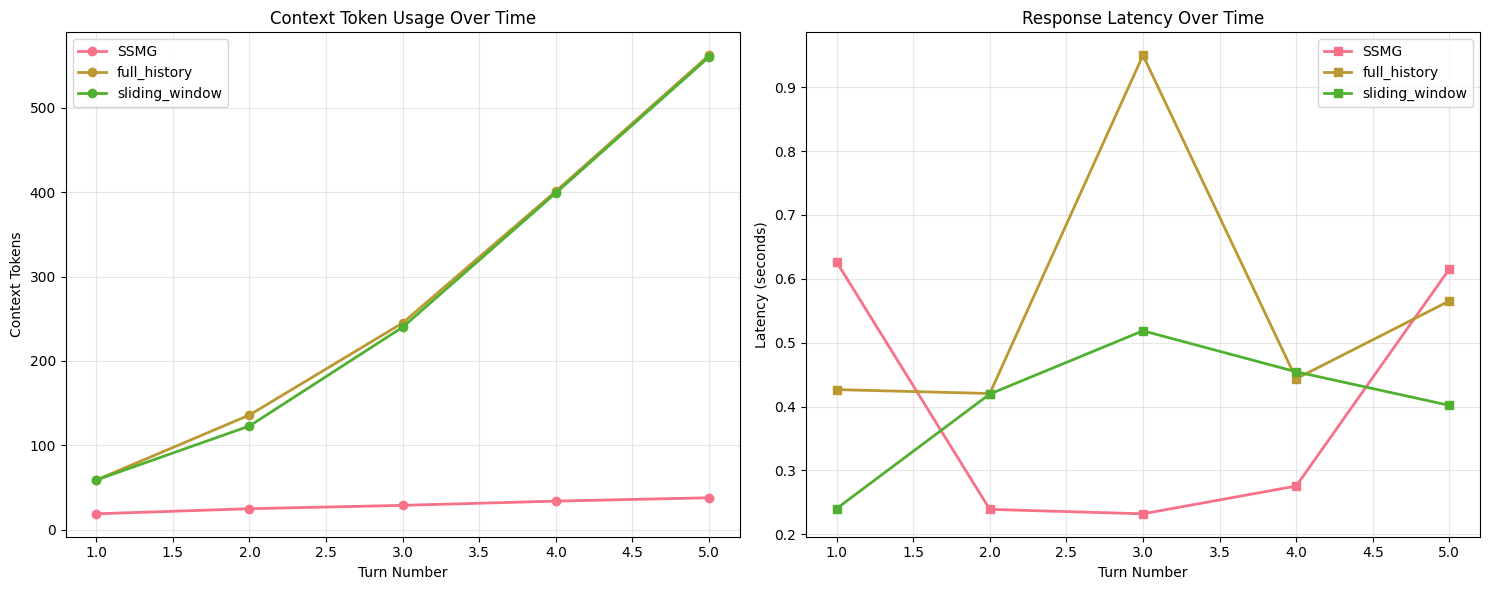


=== Performance Summary ===
               context_tokens          latency       
                         mean      std    mean    std
method                                               
SSMG                     29.0    7.450   0.398  0.204
full_history            280.6  203.080   0.561  0.225
sliding_window          276.2  204.682   0.407  0.103


In [11]:
# Prepare comparison data
comparison_data = []

for i, result in enumerate(ssmg_results):
    comparison_data.append({
        'turn': result['turn'],
        'method': 'SSMG',
        'context_tokens': result['context_tokens'],
        'latency': result['latency']
    })

comparison_data.extend(full_history_results)
comparison_data.extend(sliding_window_results)

df = pd.DataFrame(comparison_data)

# Create comparison plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Token usage over turns
for method in ['SSMG', 'full_history', 'sliding_window']:
    method_data = df[df['method'] == method]
    axes[0].plot(method_data['turn'], method_data['context_tokens'], 
                marker='o', label=method, linewidth=2, markersize=6)

axes[0].set_xlabel('Turn Number')
axes[0].set_ylabel('Context Tokens')
axes[0].set_title('Context Token Usage Over Time')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Latency comparison
for method in ['SSMG', 'full_history', 'sliding_window']:
    method_data = df[df['method'] == method]
    axes[1].plot(method_data['turn'], method_data['latency'], 
                marker='s', label=method, linewidth=2, markersize=6)

axes[1].set_xlabel('Turn Number')
axes[1].set_ylabel('Latency (seconds)')
axes[1].set_title('Response Latency Over Time')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n=== Performance Summary ===")
summary_stats = df.groupby('method').agg({
    'context_tokens': ['mean', 'std'],
    'latency': ['mean', 'std']
}).round(3)

print(summary_stats)

## 6. Graph Visualization

Let's examine the internal structure of the SSMG graph.

In [40]:
# Create a fresh session to examine graph structure
# demo_agent = SSMGDialogueAgent(llm_interface=llm)
# demo_agent.start_session("graph_demo")

# # Process a few turns to build up the graph
# demo_turns = [
#     "I want pizza but no onions",
#     "Add extra cheese",
#     "Change to pasta instead"
# ]

# for turn in demo_turns:
#     demo_agent.process_turn(turn)
demo_agent = ssmg_agent
# Examine graph structure
graph = demo_agent.graph
print(f"Graph contains {len(graph.nodes)} nodes and {len(graph.edges)} edges\n")

print("=== Graph Nodes ===")
for node_id, node in graph.nodes.items():
    print(f"{node.type.value}: {node.content} (confidence: {node.confidence:.2f}, turn: {node.turn_id})")

print("\n=== Graph Edges ===")
for edge_id, edge in graph.edges.items():
    source_content = graph.nodes[edge.source_id].content
    target_content = graph.nodes[edge.target_id].content
    print(f"{source_content} --[{edge.relation.value}]--> {target_content}")

# Show current summary
current_summary = demo_agent.summarizer.summarize(graph)
print(f"\n=== Current Context Summary ===")
print(current_summary)

demo_agent.end_session()

Graph contains 20 nodes and 0 edges

=== Graph Nodes ===
entity: pizza (confidence: 0.35, turn: 0)
entity: onions (confidence: 0.50, turn: 3)
intent: order (confidence: 0.10, turn: 0)
constraint: avoid: onions (confidence: 0.80, turn: 3)
fact: a pizza (confidence: 0.25, turn: 0)
fact: onions (confidence: 0.25, turn: 0)
entity: bread (confidence: 0.40, turn: 1)
intent: add (confidence: 0.10, turn: 1)
fact: garlic bread (confidence: 0.30, turn: 1)
entity: pasta (confidence: 0.55, turn: 3)
intent: modify (confidence: 0.18, turn: 2)
fact: pasta (confidence: 0.45, turn: 3)
intent: remove (confidence: 0.10, turn: 3)
fact: no onions (confidence: 0.40, turn: 3)
entity: cost (confidence: 0.55, turn: 4)
entity: estimate (confidence: 0.55, turn: 4)
entity: measure (confidence: 0.55, turn: 4)
intent: question (confidence: 0.24, turn: 4)
fact: the total cost estimate (confidence: 0.45, turn: 4)
fact: popular measure (confidence: 0.45, turn: 4)

=== Graph Edges ===

=== Current Context Summary ===
N

DialogueSession(session_id='demo_session', start_time=datetime.datetime(2025, 10, 6, 13, 36, 18, 843837), turns=[{'turn_id': 0, 'user_input': "I want to order a pizza. But please don't use onions.", 'assistant_response': "I'd be happy to help you order a pizza. What kind of crust would you like (thin, thick, gluten-free, etc.) and what toppings would you prefer (e.g. meats, vegetables, cheese)? I'll make sure to exclude onions from your order.", 'summary': 'No context available.', 'extraction_result': {'nodes': 6, 'edges': 0, 'confidence': 0.5722222222222222}, 'graph_state': {'total_nodes': 6, 'total_edges': 0, 'current_turn': 1}, 'timestamp': '2025-10-06T13:36:41.007241'}, {'turn_id': 1, 'user_input': 'Add garlic bread too.', 'assistant_response': "I've added garlic bread to your order. Would you like to make any other additions or proceed with the current order?", 'summary': 'No context available.', 'extraction_result': {'nodes': 3, 'edges': 0, 'confidence': 0.4222222222222222}, 'gra

## 7. Constraint Adherence Demo

Demonstrate how SSMG maintains user constraints across multiple turns.

In [13]:
# Test constraint persistence
constraint_agent = SSMGDialogueAgent(llm_interface=llm)
constraint_agent.start_session("constraint_demo")

constraint_dialogue = [
    "I'm allergic to nuts and don't like onions",
    "What pasta dishes do you recommend?",
    "How about the pesto pasta?",
    "What ingredients are in that?"
]

print("=== Constraint Adherence Test ===\n")

for i, user_input in enumerate(constraint_dialogue, 1):
    print(f"Turn {i}:")
    print(f"User: {user_input}")
    
    response, metrics = constraint_agent.process_turn(user_input)
    print(f"Assistant: {response}")
    
    # Show current constraints in graph
    constraints = constraint_agent.graph.get_nodes_by_type(constraint_agent.graph.NodeType.CONSTRAINT)
    if constraints:
        print(f"Active constraints: {[c.content for c in constraints]}")
    
    print()

constraint_agent.end_session()

=== Constraint Adherence Test ===

Turn 1:
User: I'm allergic to nuts and don't like onions
Assistant: Considering your allergy to nuts, I'll make sure to avoid those completely. And since you don't like onions, I'll exclude those as well. Can you tell me what you're looking for (e.g., a recipe, food suggestions, etc.) so I can provide you with some safe and onion-free options?


AttributeError: 'SSMGGraph' object has no attribute 'NodeType'

## 8. Token Efficiency Analysis

Analyze token savings compared to full-history approach.

=== Token Efficiency Comparison ===
SSMG total tokens: 145
Full History total tokens: 1403
Sliding Window total tokens: 1381

Token savings vs Full History: 89.7%
Token savings vs Sliding Window: 89.5%


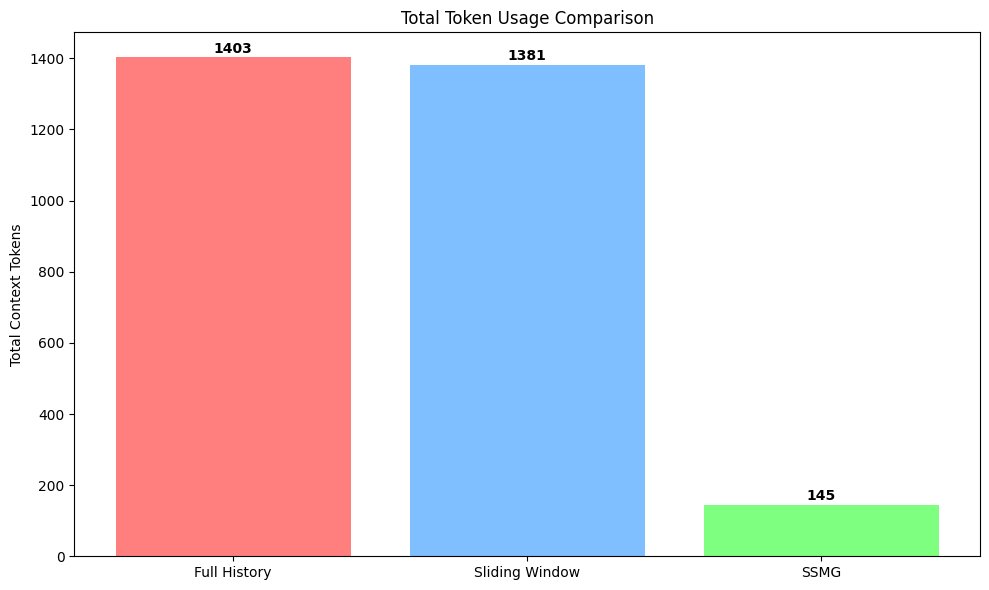

In [14]:
# Calculate token savings
ssmg_total_tokens = sum(r['context_tokens'] for r in ssmg_results)
full_history_total_tokens = sum(r['context_tokens'] for r in full_history_results)
sliding_window_total_tokens = sum(r['context_tokens'] for r in sliding_window_results)

print("=== Token Efficiency Comparison ===")
print(f"SSMG total tokens: {ssmg_total_tokens}")
print(f"Full History total tokens: {full_history_total_tokens}")
print(f"Sliding Window total tokens: {sliding_window_total_tokens}")

savings_vs_full = (full_history_total_tokens - ssmg_total_tokens) / full_history_total_tokens * 100
savings_vs_sliding = (sliding_window_total_tokens - ssmg_total_tokens) / sliding_window_total_tokens * 100

print(f"\nToken savings vs Full History: {savings_vs_full:.1f}%")
print(f"Token savings vs Sliding Window: {savings_vs_sliding:.1f}%")

# Create savings visualization
methods = ['Full History', 'Sliding Window', 'SSMG']
token_counts = [full_history_total_tokens, sliding_window_total_tokens, ssmg_total_tokens]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, token_counts, color=['#ff7f7f', '#7fbfff', '#7fff7f'])
plt.title('Total Token Usage Comparison')
plt.ylabel('Total Context Tokens')

# Add value labels on bars
for bar, count in zip(bars, token_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Key Insights

Summary of SSMG's advantages demonstrated in this notebook.

In [15]:
print("🎯 SSMG Demo Key Insights:\n")

print("1. **Context Efficiency**:")
print(f"   - SSMG uses {savings_vs_full:.1f}% fewer tokens than full history")
print(f"   - Maintains structured context vs. raw conversation history\n")

print("2. **Constraint Persistence**:")
print("   - User preferences (avoid onions, allergies) maintained across turns")
print("   - High-priority constraints protected from eviction\n")

print("3. **Reference Resolution**:")
print("   - Graph structure helps resolve pronouns and references")
print("   - Entity relationships tracked over time\n")

print("4. **Session Privacy**:")
print("   - All memory discarded at session end")
print("   - No persistent user data storage\n")

print("5. **Scalability**:")
print("   - Bounded memory usage (~50 nodes max)")
print("   - TTL eviction prevents unbounded growth")

print("📊 **Performance vs Baselines**:")
perf_df = df.groupby('method').agg({
    'context_tokens': 'mean',
    'latency': 'mean'
}).round(2)

print(perf_df)

🎯 SSMG Demo Key Insights:

1. **Context Efficiency**:
   - SSMG uses 89.7% fewer tokens than full history
   - Maintains structured context vs. raw conversation history

2. **Constraint Persistence**:
   - User preferences (avoid onions, allergies) maintained across turns
   - High-priority constraints protected from eviction

3. **Reference Resolution**:
   - Graph structure helps resolve pronouns and references
   - Entity relationships tracked over time

4. **Session Privacy**:
   - All memory discarded at session end
   - No persistent user data storage

5. **Scalability**:
   - Bounded memory usage (~50 nodes max)
   - TTL eviction prevents unbounded growth
📊 **Performance vs Baselines**:
                context_tokens  latency
method                                 
SSMG                      29.0     0.40
full_history             280.6     0.56
sliding_window           276.2     0.41


## 10. Next Steps

Try these extensions to explore SSMG further:

- **Custom Dialogues**: Modify `test_dialogue` with your own conversations
- **Parameter Tuning**: Adjust `max_nodes`, `max_ttl_turns` in graph config
- **Different Domains**: Test on hotel booking, tech support, etc.
- **Evaluation Metrics**: Run `evaluation/eval_runner.py` for comprehensive analysis
- **Production Integration**: Connect to real LLM APIs (OpenAI, etc.)

For more details, see the full evaluation in `notebooks/evaluation_analysis.ipynb`.